In [1]:
# Zachary Katz
# zachary_katz@mines.edu
# 07 May 2025

"""
Example notebook to stream and plot SWOT data

Revision History
v0.1 - 7 May 2025
    SWOT track over Bach ice shelf
"""

# Imports
%load_ext autoreload
%autoreload 2

import util.plotting_helpers as plothelp

import matplotlib.pyplot as plt
import earthaccess
import xarray as xr
import numpy as np
import rasterio
import cartopy.crs as ccrs

# Setup earthaccess.
# Follows protocol in https://book.cryointhecloud.com/how_tos/background/earthdata.html
auth = earthaccess.login(strategy="netrc")

# Locations of Antarctica polyhons
scripps_path = "../data/scripps_polygons/scripps_antarctica_polygons_v1.shp"
moa_path = "../data/moa750_2014_hp1_v01.tif"

/home/jovyan/SWOT_SURF/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Stream SWOT high resolution 100m raster
# Data info at https://podaac.jpl.nasa.gov/dataset/SWOT_L2_HR_Raster_100m_2.0
# See documentation tab for the product description document, which explain variables and file structure
# See data access -> search granules for map to search names
# Currently hardcoded one granule name, but can also search with spatial and temporal bounding boxes

results = earthaccess.search_data(
    short_name="SWOT_L2_HR_Raster_100m_2.0",
    temporal=("2024-02-12", "2025-04-15"),
    granule_name="SWOT_L2_HR_Raster_100m_UTM18C_N_x_x_x_027_393_011F*.nc",
)

swot_bach = xr.open_dataset(earthaccess.open(results)[0], engine="h5netcdf")

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 684.11it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 7973.96it/s]


In [3]:
# Read Moasiac of Antarctica (moa)
with rasterio.open(moa_path) as moa:
    bounds = moa.bounds
    left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top
    moa_dat = moa.read(1)

ext = (left, right, bottom, top)

moa = {"moa_dat": moa_dat, "extent": ext}

In [4]:
# Bach Ice Shelf bounding box
bbox = [-1920000, 480000, -1740000, 680000]

# Load Scripps grounding line
records, shapes, field_names = plothelp.load_shapefile(scripps_path)
filtered_records, filtered_shapes = plothelp.filter_shapefile(records, shapes, bbox)
scripps = {
    "records": records,
    "shapes": shapes,
    "filtered_records": filtered_records,
    "filtered_shapes": filtered_shapes,
    "field_names": field_names,
}

In [5]:
def plot_raster(size, ds, label, vmin, vmax, bbox, title, moa, to_plot, scripps):
    """
    Plot the raster data with the given parameters.
    Parameters
    size - size of fig in cm x,y
    ds - xarray dataset containing the data to plot
    label - label for the colorbar
    vmin - minimum value for the colorbar
    vmax - maximum value for the colorbar
    bbox - bounding box for the plot
    title - title for the plot
    moa - disct iwth moa raster and extent
    to_plot -variable to plot
    scripps - Dict of groudning line variables
    """

    ps71_projection = ccrs.Stereographic(
        central_latitude=-90, central_longitude=0, true_scale_latitude=-71
    )
    fig, ax = plt.subplots(
        subplot_kw={"projection": ps71_projection}, figsize=(size[0], size[1])
    )

    # REMA background
    ax.imshow(moa["moa_dat"], extent=moa["extent"], cmap="gray", vmin=15000, vmax=17000)

    plothelp.plot_shapefile(
        scripps["filtered_records"],
        scripps["filtered_shapes"],
        ax,
        scripps["field_names"],
        ["white", "none"],
        fill=False,
    )

    wse = ds[to_plot]  # .isel(num_lines=0)
    if to_plot == "wse":
        xover_corr = ds["height_cor_xover"]  # .isel(num_lines=0)
        wse = wse + xover_corr

    utm = ccrs.UTM(zone=ds.utm_zone_num, southern_hemisphere=True)
    x = wse["x"].values
    y = wse["y"].values

    X, Y = np.meshgrid(x, y)
    swot_swath = ax.pcolormesh(
        X,
        Y,
        wse.values,
        transform=utm,
        cmap="viridis",
        shading="auto",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])

    ax.set_title(title, fontsize=20, color="black")
    cbar = fig.colorbar(
        swot_swath, ax=ax, orientation="vertical", shrink=0.7, extend="max"
    )
    cbar.set_label("SWOT Elevation [m]", fontsize=18)
    cbar.ax.tick_params(labelsize=14)
    return fig, ax

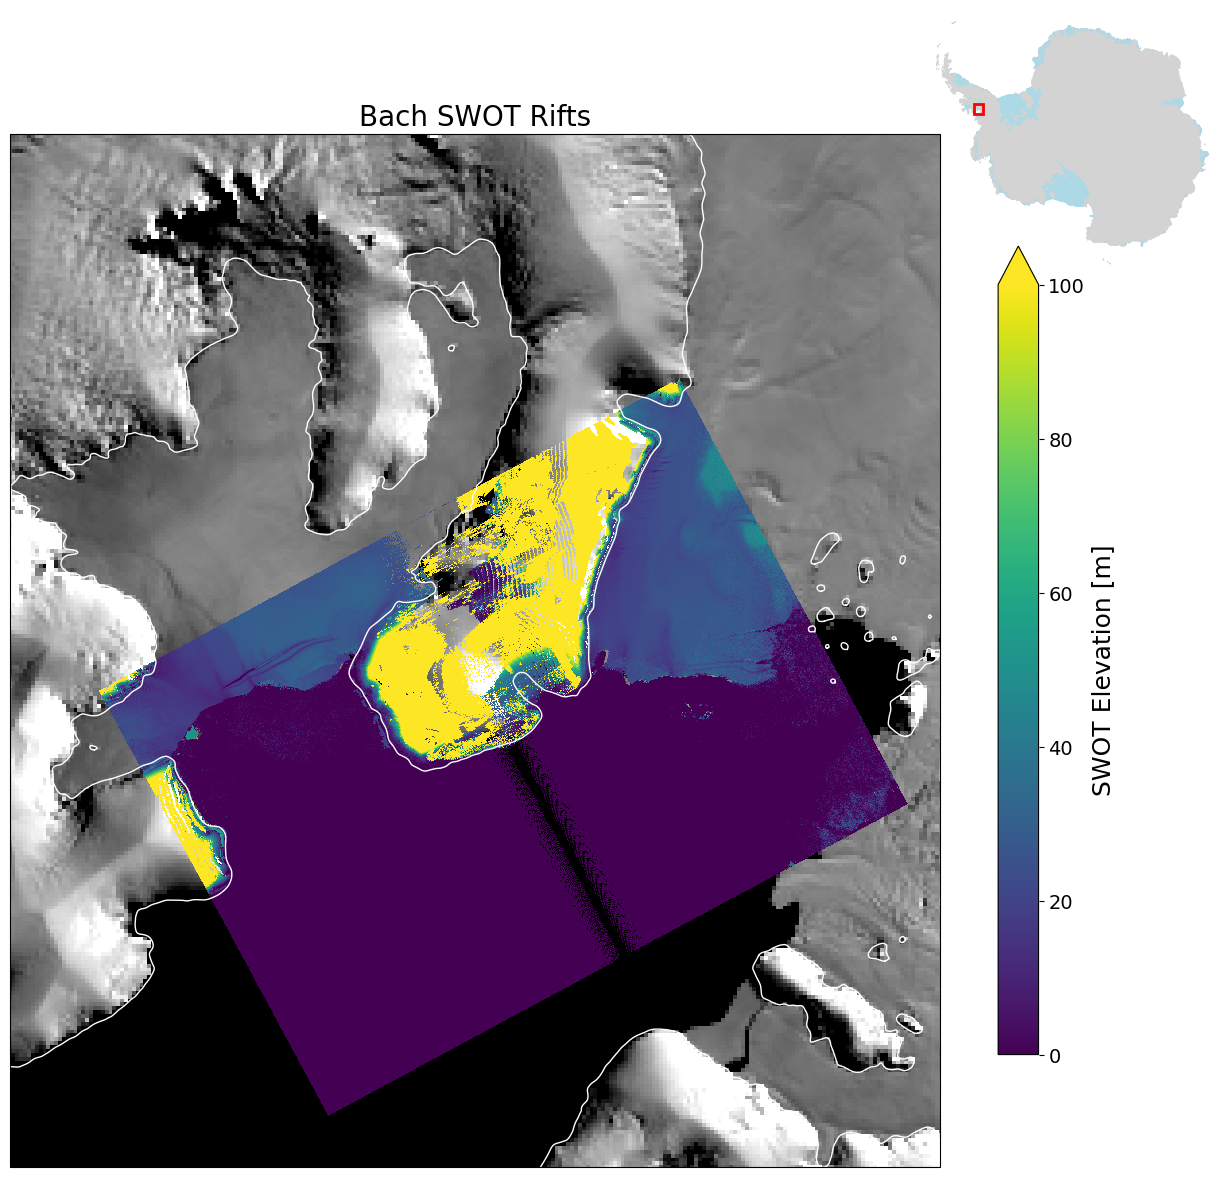

In [8]:
x_size = 15  # cm
y_size = 15  # cm
fig, ax = plot_raster(
    [x_size, y_size],
    swot_bach,
    "Height [m]",
    0,
    100,
    bbox,
    "Bach SWOT Rifts",
    moa,
    "wse",
    scripps,
)
inset = plothelp.plot_inset(
    fig,
    [11 / x_size, 11 / y_size, 3 / x_size, 3 / y_size],
    bbox,
    scripps["records"],
    scripps["shapes"],
    scripps["field_names"],
)